## 중복 값

In [1]:
df = spark.createDataFrame(
    [
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ],
    ['id', 'weight', 'height', 'age', 'gender']
)

In [2]:
print('Count of rows: {}'.format(df.count()))

Count of rows: 7


중복 값을 가지고 있는지 확인한다.  
distinct() 함수를 통해 완전히 같은 행은 제거된다.  

In [3]:
print('Count of distinct rows: {}'.format(df.distinct().count()))

Count of distinct rows: 6


dropDuplicates() 함수를 통해 완전히 같은 행을 제거할 수 있다. 

In [4]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [5]:
print('Count of ids: {}'.format(df.count()))

Count of ids: 6


id를 제외한 특성에서 중복되는 행이 존재하는지 확인한다. 

In [6]:
# 아이디를 제외한 요소에서 중복값이 몇 개 있는지 확인
print('Count of distinct ids: {}'.format(
    df.select([c for c in df.columns if c != 'id']).distinct().count()
))

Count of distinct ids: 5


subset 파라미터를 통해 중복 여부를 확인할 컬럼명을 지정한다.  
아래에서는 id를 제외한 모든 특성에서 같은 값을 가지는 row는 중복 제거된다.  
명시된 컬럼에서 중복된 행을 찾는다.  

In [7]:
df = df.dropDuplicates(
    subset=[c for c in df.columns if c != 'id']
)

In [8]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



id가 중복되는지 확인한다.  
agg() 함수를 이용하여 조회한 컬럼을 집계한다.  

In [9]:
import pyspark.sql.functions as fn

In [10]:
df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



중복된 값을 모두 제거했기 때문에 각각의 행에 고유한 id를 부여할 수 있다.  
monotonically_increasing_id() : 각 행에 고유한 값을 부여하면서 그 값을 증가시키는 함수

In [11]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



## 관찰되지 않은 데이터  

1. 삭제  
2. None 으로 채우기  
    - 평균, 중간값, 미리 정의된 다른 값 등으로 대체 가능  
    - Missing 이라는 카테고리를 추가

In [12]:
df_miss = spark.createDataFrame([
    (1, 143.5, 5.6, 28, 'M', 100000),
    (2, 167.2, 5.4, 45, 'M', None),
    (3, None, 5.2, None, None, None),
    (4, 144.5, 5.9, 33, 'M', None),
    (5, 133.2, 5.7, 54, 'F', None),
    (6, 124.1, 5.2, None, 'F', None),
    (7, 129.2, 5.3, 42, 'M', 76000),
],
['id', 'weight', 'height', 'age', 'gender', 'income']
)

미관찰 값의 개수

In [13]:
# 각 행의 미관찰 값 개수를 알아보자
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

미관찰된 값을 확인

In [14]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



각 컬럼의 미관찰 값의 비율을 계산한다.

In [15]:
# count(column) count(*) 의 차이 : null을 제외하고 행을 센다 vs null 포함 행을 센다
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c+'_missing') for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



income 특성은 미관찰 값의 비율이 71.4% 이므로 제거한다.

In [16]:
# income 제거
df_miss_no_income = df_miss.select(
    [c for c in df_miss.columns if c != 'income']
)

In [17]:
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



dropna(thresh=3) : 각 행에서 미관찰 값 개수가 3개 이상이면 해당 행을 제거  
thresh : 미관찰 값에 대한 임계치  

In [18]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [19]:
!pip install pandas

numerical 특성에 대해 각 컬럼별 평균값을 계산한다. 

toPandas() 함수는 collect() 함수 처럼 모든 정보를 worker로부터 수집한 후 드라이버 노드로 옮긴다.  

In [20]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) 
      for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

In [21]:
means['gender'] = 'missing'

fillna() 함수를 이용하여 미관찰 값에 평균값을 채워넣어 보기  
컬럼별 채울 값을 딕셔너리 형태로 전달한다.  

In [22]:
df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



## 아웃라이어

대부분의 데이터와 매우 다른 분포를 띄는 데이터  

In [23]:
df_outliers = spark.createDataFrame([
    (1, 143.5, 5.3, 28),
    (2, 154.2, 5.5, 45),
    (3, 342.3, 5.1, 99),
    (4, 144.5, 5.5, 33),
    (5, 133.2, 5.4, 54),
    (6, 124.1, 5.1, 21),
    (7, 129.2, 5.3, 42),
], ['id', 'weight', 'height', 'age'])

#### 아웃라이어 정의하기  

하위, 상위 제한선을 feature 마다 계산한다.  

In [24]:
cols = ['weight', 'height', 'age']
bounds = {}
for col in cols:
    quantiles = df_outliers.approxQuantile(
        col, [0.25, 0.75], 0.05
    )
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] + 1.5 * IQR
    ]

In [25]:
# 각 feature 의 하위, 상위 범위
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

In [26]:
outliers = df_outliers.select(
    *['id'] + 
    [((df_outliers[c] < bounds[c][0]) |
     (df_outliers[c] > bounds[c][1])).alias(c + '_o') for c in cols]
)
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



In [27]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+



In [28]:
df_outliers.filter('age_o').select('id', 'age').show()

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## 기술 통계 (Descriptive Statistics)

데이터셋에서 관찰 값의 개수, 각 컬럼의 평균/표준편차/최댓값/최솟값 등의 기본 통계 정보  

In [29]:
import pyspark.sql.types as typ

In [30]:
fraud = sc.textFile('file:///home/an/nb-workspace/data/ccFraud.csv')

In [31]:
header = fraud.first()

In [32]:
fraud = fraud.filter(lambda row: row != header)\
             .map(lambda row: [int(elem) for elem in row.split(',')])

In [33]:
fields = [
    *[typ.StructField(h[1:-1], typ.IntegerType(), True) for h in header.split(',')]
]

In [34]:
schema = typ.StructType(fields)

In [35]:
fraud_df = spark.createDataFrame(fraud, schema)

In [36]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [37]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



numerical column에 대해 describe()를 사용할 수 있다.

변동 계수 (coefficient variabioin) : 평균과 표준 편차의 비율  
\- 모든 특성이 큰 값을 가진다. (1에 가까울 수록 넓게 퍼진 데이터를 의미함)  

세 특성 모두 양의 방향으로 왜곡되었다. (최댓값이 평균값보다 몇 배 이상 큼)

In [38]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [39]:
df = desc.toPandas()

In [40]:
float(df.iloc[2,1]) / float(df.iloc[1, 1])

0.9724878801088658

In [41]:
float(df.iloc[2,2]) / float(df.iloc[1, 2])

0.9176986114778958

In [42]:
float(df.iloc[2,3]) / float(df.iloc[1, 3])

2.1256650486956157

비대칭도를 확인하기

In [43]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



## 상관 계수

서로 다른 특성들 간의 상호 관계를 나타내는 측정값  

일반적으로 모델은 서로 상관계수가 높은 특성들을 포함하지 않는다.  
corr() 함수는 피어슨 상관계수로 두 쌍의 상관계수만을 지원한다.  

In [44]:
fraud_df.corr('balance', 'numTrans')

0.0004452314017265386

In [45]:
n_numerical = len(numerical)
corr = []
for i in range(0, n_numerical):
    temp = [None] * i
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

In [46]:
corr

[[1.0, 0.0004452314017265386, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

## 시각화

In [47]:
%matplotlib inline

In [48]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### 히스토그램

PySpark에서 만드는 방법은 3가지이다.  
1. 데이터를 워커 노드에서 집계하고 워커 노드가 bin 리스트를 드라이버 노드에게 리턴 후 각 bin의 개수를 드라이버 노드가 센다.  
2. 데이터를 모두 드라이버 노드에게 리턴하고, 시각화 라이브러리 함수를 사용해 히스토그램을 만든다. (데이터의 수가 너무 많으면 불가능한 방법)  
3. 데이터를 샘플링해 드라이버 노드에 리턴한다. 드라이버 노드는 리턴된 데이터를 이용해 데이터를 시각화한다.  

In [49]:
# 데이터를 먼저 집계한다
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 1.0, "Histogram of 'balance'")

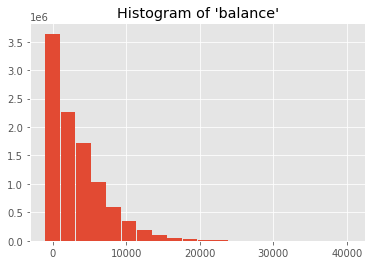

In [50]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
# matplotlib를 이용하여 그린다
plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

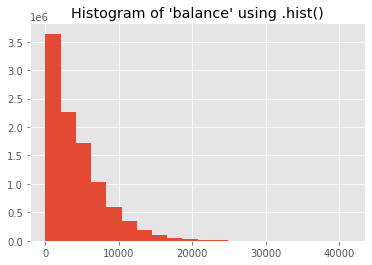

In [51]:
# 드라이버 노드에서 모두 처리할 수 있을만큼 데이터가 적을 때 데이터를 가져와서 시각화
data_driver = {
    'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()
}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

#### Scatter chart

세 변수 간의 상호작용을 시각화할 수 있다.  

PySpark는 서버측에서 어떤 시각화 모듈도 제공하지 않는다.  
따라서 수십억 개의 데이터를 동시에 시각화하는 것이 비현실적이다.  

데이터가 아주 많은 경우  
정해진 샘플링 비율로 3 ~ 5개의 샘플을 준비한다.  
샘플링된 데이터셋이 전체를 대표할 수 있는지 체크할 수 있다.  

여기서는 2,000개의 데이터를 샘플링한다. (Fraud 데이터셋에서 0.02%이다.)  

In [52]:
# 0.02 % 를 샘플링
data_sample = fraud_df.sampleBy(
    'gender', {1: 0.0002, 2: 0.0002}
).select(numerical)

In [53]:
data_multi = dict(
    [(elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical]
)

Text(0, 0.5, 'numTrans')

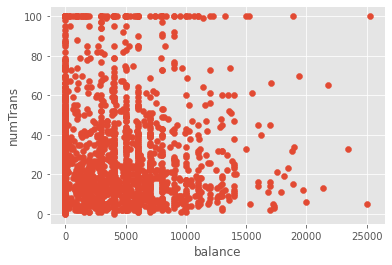

In [54]:
plt.scatter(data_multi['balance'], data_multi['numTrans'])
plt.xlabel('balance')
plt.ylabel('numTrans')

In [55]:
fraud_df.count()

10000000

In [56]:
data_sample.count()

1951